In [1]:
import os

import geopandas as gpd
import pandas as pd
import numpy as np
import shapely
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopy
import urllib
from shapely.geometry import shape
import contextily as ctx


with_plotly = False # Preferably to True, but in case plotly cannot be installer, this allows the notebook to work
if with_plotly:
    import plotly.express as px
    import plotly.graph_objects as go

In [2]:
crs =     'epsg:3857'
osm_crs=  'epsg:4326'

# Functions

In [3]:
def download_if_nexist(url, filename):
    """
    If the (local) file <filename> does not exists, download it from <url> 

    Parameters
    ----------
    url: str
       url to fecth
    filename: str
       local file to save

    Returns
    -------

    None
    """
    if not os.path.isfile(filename):
        with urllib.request.urlopen(url) as response:
            with open(filename, "wb") as f:
                f.write(response.read())

In [4]:
def get_osm_polyg(name):
    """
    Request Nominatim (OpenStreetMap) for "name", and returns the polygon (or point) given in the (first) result
    
    Parameters
    ----------
    name: str
        
    """
    url = f"http://nominatim.openstreetmap.org/search.php?q={name}&format=json&limit=1&polygon_geojson=1"
    with urllib.request.urlopen(url) as response:
        json_res = json.loads(response.read())
        if len(json_res)==0:
            return None
        return shape(json_res[0]["geojson"])


# Load data

## Zip code list

Get the official list of Belgian zipcodes, provided by BPost. Some of them correspond to real (sub)-localities, other are "special codes", corresponding to some institutions (Parliaments, ...) or companies (RTBF, 3 Suisses, ...)

This source does not contain any geographical informations

If several entities share the same zipcode, this zipcode appears in several records

In [5]:
download_if_nexist("https://www.bpost2.be/zipcodes/files/zipcodes_alpha_fr_new.xls",
                  "data/zipcodes_alpha_fr_new.xls")

zipcodes = pd.read_excel("data/zipcodes_alpha_fr_new.xls")
zipcodes = zipcodes.rename({"Code postal":"zipcode", "Commune principale": "main_commune", "Localité":"locality"}, axis=1)
zipcodes["zipcode"] = zipcodes["zipcode"].astype(str)
zipcodes["is_special"] = zipcodes["Sous-commune"].isnull()
print(zipcodes.zipcode.nunique(), "unique zipcodes")
zipcodes

1190 unique zipcodes


zipcode         locality Sous-commune main_commune             Province  \
0       2970   'S Gravenwezel          Oui      SCHILDE               ANVERS   
1       3700  'S Herenelderen          Oui     TONGEREN             LIMBOURG   
2       7510        3 Suisses          NaN    3 Suisses                  NaN   
3       9420           Aaigem          Oui    ERPE-MERE    FLANDRE-ORIENTALE   
4       8511          Aalbeke          Oui     KORTRIJK  FLANDRE-OCCIDENTALE   
...      ...              ...          ...          ...                  ...   
2760    3690        Zutendaal          Non    ZUTENDAAL             LIMBOURG   
2761    8550         Zwevegem          Non     ZWEVEGEM  FLANDRE-OCCIDENTALE   
2762    8750        Zwevezele          Oui      WINGENE  FLANDRE-OCCIDENTALE   
2763    9052       Zwijnaarde          Oui         GENT    FLANDRE-ORIENTALE   
2764    2070      Zwijndrecht          Non  ZWIJNDRECHT               ANVERS   

      is_special  
0          False  
1          False  
2           True  
3          False  
4          False  
...          ...  
2760       False  
2761       False  
2762       False  
2763       False  
2764       False  

[2765 rows x 6 columns]

### Some stats

In [6]:
zipcodes_normal = zipcodes[~zipcodes.is_special]

In [7]:
print("Number of zipcodes:", zipcodes.zipcode.nunique())
print("Number of (not special) zipcodes :", zipcodes_normal.zipcode.nunique())
print("Number of (main) communes:", (zipcodes_normal.main_commune+"_"+zipcodes_normal.Province).nunique())

Number of zipcodes: 1190
Number of (not special) zipcodes : 1146
Number of (main) communes: 581


In [8]:
commune_stats =zipcodes_normal.groupby("main_commune")[["zipcode", "locality"]].nunique()
commune_stats

zipcode  locality
main_commune                   
AALST               4         9
AALTER              3         6
AARSCHOT            3         4
AARTSELAAR          1         1
AFFLIGEM            1         4
...               ...       ...
ZULTE               1         3
ZUTENDAAL           1         1
ZWALM               2        12
ZWEVEGEM            5         5
ZWIJNDRECHT         1         2

[581 rows x 2 columns]

In [9]:
pd.DataFrame(columns = ["#zipcodes", "#localities", "#commune"],
             data=[["=1", "=1",   commune_stats.query("(zipcode==1) & (locality == 1)").shape[0]],
 ["=1", ">1",   commune_stats.query("(zipcode==1) & (locality>1)").shape[0]],
 [">1", "=zip", commune_stats.query("(zipcode >1) & (zipcode==locality)").shape[0]],
 [">1", "<zip", commune_stats.query("(zipcode >1) & (zipcode<locality)").shape[0]],
 [">1", ">zip", commune_stats.query("(zipcode >1) & (zipcode>locality)").shape[0]] 
])

#zipcodes #localities  #commune
0        =1          =1        98
1        =1          >1       261
2        >1        =zip        53
3        >1        <zip       168
4        >1        >zip         1

In [10]:
print("Communes with a locality having the same name")
display(zipcodes_normal[(zipcodes_normal.locality.str.upper() == zipcodes_normal.main_commune)])
print("Number of (unique) communes:", zipcodes_normal[(zipcodes_normal.locality.str.upper() == zipcodes_normal.main_commune)].main_commune.nunique())

Communes with a locality having the same name


zipcode     locality Sous-commune main_commune             Province  \
6       9300        Aalst          Non        AALST    FLANDRE-ORIENTALE   
7       9880       Aalter          Non       AALTER    FLANDRE-ORIENTALE   
8       3200     Aarschot          Non     AARSCHOT      BRABANT FLAMAND   
11      2630   Aartselaar          Non   AARTSELAAR               ANVERS   
22      1790     Affligem          Non     AFFLIGEM      BRABANT FLAMAND   
...      ...          ...          ...          ...                  ...   
2757    8377   Zuienkerke          Non   ZUIENKERKE  FLANDRE-OCCIDENTALE   
2758    9870        Zulte          Non        ZULTE    FLANDRE-ORIENTALE   
2760    3690    Zutendaal          Non    ZUTENDAAL             LIMBOURG   
2761    8550     Zwevegem          Non     ZWEVEGEM  FLANDRE-OCCIDENTALE   
2764    2070  Zwijndrecht          Non  ZWIJNDRECHT               ANVERS   

      is_special  
6          False  
7          False  
8          False  
11         False  
22         False  
...          ...  
2757       False  
2758       False  
2760       False  
2761       False  
2764       False  

[528 rows x 6 columns]

Number of (unique) communes: 521


In [11]:
zipcodes_normal[zipcodes_normal["Sous-commune"] == "Non"]

zipcode     locality Sous-commune main_commune             Province  \
6       9300        Aalst          Non        AALST    FLANDRE-ORIENTALE   
7       9880       Aalter          Non       AALTER    FLANDRE-ORIENTALE   
8       3200     Aarschot          Non     AARSCHOT      BRABANT FLAMAND   
11      2630   Aartselaar          Non   AARTSELAAR               ANVERS   
22      1790     Affligem          Non     AFFLIGEM      BRABANT FLAMAND   
...      ...          ...          ...          ...                  ...   
2757    8377   Zuienkerke          Non   ZUIENKERKE  FLANDRE-OCCIDENTALE   
2758    9870        Zulte          Non        ZULTE    FLANDRE-ORIENTALE   
2760    3690    Zutendaal          Non    ZUTENDAAL             LIMBOURG   
2761    8550     Zwevegem          Non     ZWEVEGEM  FLANDRE-OCCIDENTALE   
2764    2070  Zwijndrecht          Non  ZWIJNDRECHT               ANVERS   

      is_special  
6          False  
7          False  
8          False  
11         False  
22         False  
...          ...  
2757       False  
2758       False  
2760       False  
2761       False  
2764       False  

[528 rows x 6 columns]

In [12]:
zipcodes[zipcodes.main_commune.isin(zipcodes[(zipcodes.locality.str.upper() == zipcodes.main_commune)].main_commune)].main_commune.nunique()

529

In [13]:
z_dup = zipcodes[(zipcodes.locality.str.upper() == zipcodes.main_commune)]
z_dup[z_dup.duplicated(subset="main_commune")]#.main_commune.nunique()

zipcode   locality Sous-commune main_commune Province  is_special
61      2018  Antwerpen          Non    ANTWERPEN   ANVERS       False
62      2020  Antwerpen          Non    ANTWERPEN   ANVERS       False
63      2030  Antwerpen          Non    ANTWERPEN   ANVERS       False
64      2040  Antwerpen          Non    ANTWERPEN   ANVERS       False
65      2050  Antwerpen          Non    ANTWERPEN   ANVERS       False
66      2060  Antwerpen          Non    ANTWERPEN   ANVERS       False
1360    4020      Liège          Non        LIÈGE    LIEGE       False

In [14]:
zipcodes[(zipcodes.locality.str.upper() == zipcodes.main_commune) & ~zipcodes.is_special]

zipcode     locality Sous-commune main_commune             Province  \
6       9300        Aalst          Non        AALST    FLANDRE-ORIENTALE   
7       9880       Aalter          Non       AALTER    FLANDRE-ORIENTALE   
8       3200     Aarschot          Non     AARSCHOT      BRABANT FLAMAND   
11      2630   Aartselaar          Non   AARTSELAAR               ANVERS   
22      1790     Affligem          Non     AFFLIGEM      BRABANT FLAMAND   
...      ...          ...          ...          ...                  ...   
2757    8377   Zuienkerke          Non   ZUIENKERKE  FLANDRE-OCCIDENTALE   
2758    9870        Zulte          Non        ZULTE    FLANDRE-ORIENTALE   
2760    3690    Zutendaal          Non    ZUTENDAAL             LIMBOURG   
2761    8550     Zwevegem          Non     ZWEVEGEM  FLANDRE-OCCIDENTALE   
2764    2070  Zwijndrecht          Non  ZWIJNDRECHT               ANVERS   

      is_special  
6          False  
7          False  
8          False  
11         False  
22         False  
...          ...  
2757       False  
2758       False  
2760       False  
2761       False  
2764       False  

[528 rows x 6 columns]

In [15]:
zipcodes[zipcodes["Sous-commune"] == "Non"]#.zipcode.nunique()

zipcode     locality Sous-commune main_commune             Province  \
6       9300        Aalst          Non        AALST    FLANDRE-ORIENTALE   
7       9880       Aalter          Non       AALTER    FLANDRE-ORIENTALE   
8       3200     Aarschot          Non     AARSCHOT      BRABANT FLAMAND   
11      2630   Aartselaar          Non   AARTSELAAR               ANVERS   
22      1790     Affligem          Non     AFFLIGEM      BRABANT FLAMAND   
...      ...          ...          ...          ...                  ...   
2757    8377   Zuienkerke          Non   ZUIENKERKE  FLANDRE-OCCIDENTALE   
2758    9870        Zulte          Non        ZULTE    FLANDRE-ORIENTALE   
2760    3690    Zutendaal          Non    ZUTENDAAL             LIMBOURG   
2761    8550     Zwevegem          Non     ZWEVEGEM  FLANDRE-OCCIDENTALE   
2764    2070  Zwijndrecht          Non  ZWIJNDRECHT               ANVERS   

      is_special  
6          False  
7          False  
8          False  
11         False  
22         False  
...          ...  
2757       False  
2758       False  
2760       False  
2761       False  
2764       False  

[528 rows x 6 columns]

In [16]:
zipcodes[~zipcodes.main_commune.isin(zipcodes[zipcodes["Sous-commune"] == "Non"].main_commune) & ~zipcodes.is_special]

zipcode   locality Sous-commune           main_commune  \
3       9420     Aaigem          Oui              ERPE-MERE   
14      3930      Achel          Oui           HAMONT-ACHEL   
24      5544    Agimont          Oui               HASTIÈRE   
27      6250     Aiseau          Oui         AISEAU-PRESLES   
35      6680  Amberloup          Oui             SAINTE-ODE   
...      ...        ...          ...                    ...   
2707    8952  Wulvergem          Oui             HEUVELLAND   
2742    3271     Zichem          Oui  SCHERPENHEUVEL-ZICHEM   
2745    9750     Zingem          Oui                KRUISEM   
2749    9930   Zomergem          Oui               LIEVEGEM   
2759    9690    Zulzeke          Oui            KLUISBERGEN   

                 Province  is_special  
3       FLANDRE-ORIENTALE       False  
14               LIMBOURG       False  
24                  NAMUR       False  
27                HAINAUT       False  
35             LUXEMBOURG       False  
...                   ...         ...  
2707  FLANDRE-OCCIDENTALE       False  
2742      BRABANT FLAMAND       False  
2745    FLANDRE-ORIENTALE       False  
2749    FLANDRE-ORIENTALE       False  
2759    FLANDRE-ORIENTALE       False  

[308 rows x 6 columns]

In [17]:
528+96

624

## Zip code centers

Get a list giving for each zipcode, its locality name, and geographical center.


Note : it does not contain any "special zicode"

In [18]:
# https://data.gov.be/fr/dataset/328ba4f140ba0e870dfc9c70635fe7c1840980b1
download_if_nexist("https://www.odwb.be/api/v2/catalog/datasets/code-postaux-belge/exports/geojson",
                  "data/zipcode_centers.geojson")

zipcodes_centers = gpd.read_file("data/zipcode_centers.geojson")
zipcodes_centers = zipcodes_centers.rename({"column_1": "zipcode", "column_2": "locality"}, axis=1)[["locality","zipcode", "geometry"]]

zipcodes_centers = zipcodes_centers.to_crs(crs)
print(zipcodes_centers.zipcode.nunique(), "unique zipcode")
zipcodes_centers

1145 unique zipcode


locality zipcode                        geometry
0                 Ixelles    1050  POINT (487754.219 6589918.068)
1              Koekelberg    1081  POINT (481535.656 6596965.764)
2                   Haren    1130  POINT (491205.143 6602205.979)
3     Woluwe-Saint-Pierre    1150  POINT (494625.526 6591144.170)
4                 Incourt    1315  POINT (534216.002 6566956.791)
...                   ...     ...                             ...
2752             Ertvelde    9940  POINT (417134.047 6653080.277)
2753            Boekhoute    9961  POINT (412545.747 6665801.135)
2754    Sint-Jan-In-Eremo    9982  POINT (398534.241 6668876.259)
2755    Waterland-Oudeman    9988  POINT (399698.031 6672595.592)
2756             Maldegem    9990  POINT (380206.578 6661423.982)

[2757 rows x 3 columns]

In [19]:
# Missing zipcode
zipcodes[~zipcodes.zipcode.isin(zipcodes_centers.zipcode) & ~zipcodes.is_special]

zipcode        locality Sous-commune main_commune Province  is_special
1895    5352  Perwez-Haillot          Oui         OHEY    NAMUR       False

## Zip code boundaries

Get the boundaries for all zipcodes. Provided by BPost.

In the original files, multi-polygons as given as multiple (single)-polygons records. We merge them in ony one record.

Note that in the "center" file, if several entities share the same zip, the center of each entity is given, while here, we only have one (multi-)polygon per zipcode.

In [20]:
zipcode_boundaries_filename = "data/zipcode_boundaries_shapefile_3812.zip"

In [21]:
# https://www.geo.be/catalog/details/9738c7c0-5255-11ea-8895-34e12d0f0423?l=fr
download_if_nexist("https://bgu.bpost.be/assets/9738c7c0-5255-11ea-8895-34e12d0f0423_x-shapefile_3812.zip",
                  zipcode_boundaries_filename)

In [22]:
zipcodes_boundaries = gpd.read_file(f"zip://{zipcode_boundaries_filename}/3812")
zipcodes_boundaries["is_special"] = zipcodes_boundaries.CP_speciau ==1
zipcodes_boundaries = zipcodes_boundaries.rename({"nouveau_PO":"zipcode"}, axis=1)[["zipcode", "is_special", "geometry"]]

zipcodes_boundaries = zipcodes_boundaries.dissolve(["zipcode", "is_special"]).reset_index()

zipcodes_boundaries = zipcodes_boundaries.to_crs(crs)
zipcodes_boundaries

zipcode  is_special                                           geometry
0       1000       False  MULTIPOLYGON Z (((487951.058 6600061.994 0.000...
1       1005        True  POLYGON Z ((484391.808 6593846.983 0.000, 4844...
2       1006        True  POLYGON Z ((484413.037 6593943.815 0.000, 4843...
3       1007        True  POLYGON Z ((486232.320 6594255.851 0.000, 4862...
4       1008        True  POLYGON Z ((486000.332 6594258.665 0.000, 4858...
...      ...         ...                                                ...
1182    9982       False  POLYGON Z ((398126.149 6670079.581 0.000, 3981...
1183    9988       False  POLYGON Z ((402165.046 6674165.098 0.000, 4021...
1184    9990       False  POLYGON Z ((383123.261 6664423.574 0.000, 3831...
1185    9991       False  POLYGON Z ((389466.378 6660430.021 0.000, 3895...
1186    9992       False  POLYGON Z ((376698.000 6669876.805 0.000, 3767...

[1187 rows x 3 columns]

In [23]:
# Missing zipcode
zipcodes[~zipcodes.zipcode.isin(zipcodes_boundaries.zipcode)]

zipcode    locality Sous-commune   main_commune    Province  is_special
1175    6642     Juseret          Oui  VAUX-SUR-SÛRE  LUXEMBOURG       False
1939    1100  Postcheque          NaN     Postcheque         NaN        True
2140    1101    Scanning          NaN       Scanning         NaN        True
2551    1818         VTM          NaN            VTM         NaN        True

In [24]:
# Extra zipcode
zipcodes_boundaries[~zipcodes_boundaries.zipcode.isin(zipcodes.zipcode)]

zipcode  is_special                                           geometry
1071       9       False  POLYGON Z ((551743.087 6617609.407 0.000, 5517...

## NIS code boundaries

Get boundaries for all statistical sectors, from StatBel. Statistical sectors can be grouped by NIS code, providing NIS code boundaries.

In [25]:
# https://statbel.fgov.be/fr/open-data/secteurs-statistiques-2020

download_if_nexist("https://statbel.fgov.be/sites/default/files/files/opendata/Statistische%20sectoren/sh_statbel_statistical_sectors_31370_20200101.shp.zip",
                   "data/stat_sectors_2020.zip")
statistical_sectors = gpd.read_file("zip://data/stat_sectors_2020.zip/sh_statbel_statistical_sectors_20200101.shp")
statistical_sectors["CNIS5_2020"] = statistical_sectors["CNIS5_2020"].astype(str)

In [26]:
nis_boundaries = statistical_sectors[["CNIS5_2020", "T_MUN_FR", "T_MUN_NL", "geometry"]].dissolve(by="CNIS5_2020").reset_index()
nis_boundaries = nis_boundaries.rename({"CNIS5_2020": "niscode"}, axis=1)
nis_boundaries = nis_boundaries.to_crs(crs)

# Spatial join : polygon vs point

As a first example of spatial join, we will join polygons (from zipcodes_boundaries) and points (from zipcodes_centers).

In the resulting table sjoin_zip_center, we'll get all combination of zipcodes_boundaries and zipcodes_centers, where the point of zipcodes_centers falls into the polygon of zipcodes_boundaries.

sjoin_mismatches will contain all combinations where the zipcode provided by zipcodes_centers does not match the zipcode provided by zipcodes_boundaries

In [27]:
sjoin_zip_center = gpd.sjoin(zipcodes_boundaries, zipcodes_centers)
sjoin_zip_center

zipcode_left  is_special  \
0            1000       False   
8            1020       False   
9            1030       False   
13           1040       False   
21           1050       False   
...           ...         ...   
1183         9988       False   
1183         9988       False   
1184         9990       False   
1185         9991       False   
1186         9992       False   

                                               geometry  index_right  \
0     MULTIPOLYGON Z (((487951.058 6600061.994 0.000...         1678   
8     POLYGON Z ((484519.836 6603848.988 0.000, 4845...         1139   
9     POLYGON Z ((488633.964 6600056.547 0.000, 4887...         1140   
13    MULTIPOLYGON Z (((486480.015 6594068.947 0.000...         2214   
21    MULTIPOLYGON Z (((486898.793 6593112.249 0.000...            0   
...                                                 ...          ...   
1183  POLYGON Z ((402165.046 6674165.098 0.000, 4021...          547   
1183  POLYGON Z ((402165.046 6674165.098 0.000, 4021...         2755   
1184  POLYGON Z ((383123.261 6664423.574 0.000, 3831...         2756   
1185  POLYGON Z ((389466.378 6660430.021 0.000, 3895...         2212   
1186  POLYGON Z ((376698.000 6669876.805 0.000, 3767...         2213   

               locality zipcode_right  
0             Bruxelles          1000  
8                Laeken          1020  
9            Schaerbeek          1030  
13            Etterbeek          1040  
21              Ixelles          1050  
...                 ...           ...  
1183         Watervliet          9988  
1183  Waterland-Oudeman          9988  
1184           Maldegem          9990  
1185             Adegem          9991  
1186         Middelburg          9992  

[2757 rows x 6 columns]

In [28]:
sjoin_mismatches = sjoin_zip_center[sjoin_zip_center.zipcode_left != sjoin_zip_center.zipcode_right].reset_index(drop=True)
sjoin_mismatches

zipcode_left  is_special  \
0          1130       False   
1          1541       False   
2          2000       False   
3          2000       False   
4          2000       False   
5          2000       False   
6          2000       False   
7          2000       False   
8          2180       False   
9          2180       False   
10         2490       False   
11         2490       False   
12         2560       False   
13         3202       False   
14         3300       False   
15         3700       False   
16         3770       False   
17         4000       False   
18         4120       False   
19         4122       False   
20         4141       False   
21         4400       False   
22         4852       False   
23         4910       False   
24         4910       False   
25         4910       False   
26         4960       False   
27         4987       False   
28         4987       False   
29         4987       False   
30         5541       False   
31         5576       False   
32         6640       False   
33         6666       False   
34         6681       False   
35         6724       False   
36         6820       False   
37         7141       False   
38         7624       False   
39         7811       False   
40         8301       False   
41         8620       False   
42         8755       False   
43         8952       False   
44         9120       False   
45         9130       False   
46         9180       False   
47         9180       False   
48         9220       False   
49         9620       False   
50         9620       False   
51         9790       False   

                                             geometry  index_right  \
0   POLYGON Z ((492165.130 6604187.117 0.000, 4921...         1264   
1   POLYGON Z ((442698.747 6572867.831 0.000, 4427...         1047   
2   POLYGON Z ((491447.469 6663216.307 0.000, 4914...         1198   
3   POLYGON Z ((491447.469 6663216.307 0.000, 4914...         2256   
4   POLYGON Z ((491447.469 6663216.307 0.000, 4914...         2255   
5   POLYGON Z ((491447.469 6663216.307 0.000, 4914...          593   
6   POLYGON Z ((491447.469 6663216.307 0.000, 4914...         1736   
7   POLYGON Z ((491447.469 6663216.307 0.000, 4914...         2259   
8   POLYGON Z ((496588.712 6668893.730 0.000, 4964...         1245   
9   POLYGON Z ((496588.712 6668893.730 0.000, 4964...         2262   
10  POLYGON Z ((579405.019 6646044.757 0.000, 5793...         1263   
11  POLYGON Z ((579405.019 6646044.757 0.000, 5793...         2252   
12  POLYGON Z ((522581.783 6652932.359 0.000, 5226...         2350   
13  POLYGON Z ((545421.333 6620399.304 0.000, 5454...         1798   
14  POLYGON Z ((546638.037 6597317.597 0.000, 5466...          106   
15  POLYGON Z ((613768.565 6589710.582 0.000, 6137...          683   
16  POLYGON Z ((625035.587 6592809.132 0.000, 6250...         1657   
17  MULTIPOLYGON Z (((622294.900 6548667.801 0.000...          151   
18  POLYGON Z ((604356.408 6544578.503 0.000, 6043...          181   
19  POLYGON Z ((617503.511 6544062.555 0.000, 6175...          701   
20  POLYGON Z ((640688.017 6541527.140 0.000, 6406...         2429   
21  POLYGON Z ((609617.951 6554549.539 0.000, 6096...         2564   
22  POLYGON Z ((664231.609 6575203.101 0.000, 6642...          778   
23  POLYGON Z ((654464.107 6535116.816 0.000, 6544...         2538   
24  POLYGON Z ((654464.107 6535116.816 0.000, 6544...         1943   
25  POLYGON Z ((654464.107 6535116.816 0.000, 6544...         2423   
26  POLYGON Z ((680570.480 6512355.732 0.000, 6805...          340   
27  POLYGON Z ((651334.479 6514275.104 0.000, 6512...          855   
28  POLYGON Z ((651334.479 6514275.104 0.000, 6512...         1366   
29  POLYGON Z ((651334.479 6514275.104 0.000, 6512...         1342   
30  POLYGON Z ((538168.187 6483865.512 0.000, 5382...          835   
31  POLYGON Z ((558829.518 6455080.381 0.000, 5589...          263   
32  POLYGON Z ((627657.956 6447744.344 0.000, 627

We can now explore all those mismatch. As a way to make decisions easier, we provide several data: 
- The mismatch record (with two different zipcodes zip1, zip2)
- Information we have from BPost for the two zipcodes
- What OpenStreetMap knows at the point given by zipcodes_centers
- What OpenStreetMap knows for the given locality (in zipcodes_centers)
- A map with : 
    - the boundaries corresponding to zip1 and zip2 in zipcodes_boundaries et 
    - all points corresponding to zip1 and zip2 in zipcodes_centers

In [41]:
def plot_mismatch_zip(sjoin_mismatches, i):
    print(f"Mismatch record {i}:")
    display(sjoin_mismatches.iloc[[i]])

    zip1 = sjoin_mismatches.iloc[i].zipcode_left
    zip2 = sjoin_mismatches.iloc[i].zipcode_right

    print("From BPost:")
    display( zipcodes[ zipcodes.zipcode.isin([zip1, zip2])])

    try: 
        print("Know by OSM at the given point:")
        pt = zipcodes_centers.to_crs(osm_crs).loc[sjoin_mismatches.iloc[i].index_right].geometry
        geolocator = geopy.geocoders.Nominatim(user_agent="smalsresearch")
        print(geolocator.reverse(f"{pt.y}, {pt.x}").address)

        print("Know by OSM for the given locality:")
        loc = zipcodes_centers.loc[sjoin_mismatches.iloc[i].index_right].locality
        print(geolocator.geocode(f"{loc}, Belgium").address)
    except Exception as e:
        print("Cannot get OSM data:", e)

    query = f"zipcode in ('{zip1}', '{zip2}')"


    df_bnd = zipcodes_boundaries.assign(label=zipcodes_boundaries.zipcode).query(query).to_crs(osm_crs)
    df_pnt = zipcodes_centers.assign(label=zipcodes_centers.zipcode+" "+zipcodes_centers.locality).query(query).to_crs(osm_crs)

    df_pnt["mismatch"] = False
    df_pnt.loc[sjoin_mismatches.iloc[i].index_right, "mismatch"] = True

    if with_plotly:
        fig = px.choropleth_mapbox(df_bnd, 
                                   geojson=df_bnd.geometry, 
                                   locations=df_bnd.index, 
                                   hover_name="label",
                                   color=df_bnd['label'],
                                   center={"lat": df_bnd.bounds.mean()[["miny", "maxy"]].mean(), 
                                           "lon": df_bnd.bounds.mean()[["minx", "maxx"]].mean()},
                                   mapbox_style="open-street-map",
                                   #zoom=10,
                                   opacity=0.5,

                           )

        for i, bloc in df_pnt.groupby("mismatch"): 
            fig.add_trace(go.Scattermapbox(lat=bloc.geometry.y,
                                           lon=bloc.geometry.x,
                                           mode='markers+text', # "markers+text",
                                           text=bloc.label, 
                                           name="Zipcode centers" + (" (mismatch)" if i else ""),
                                           textposition="bottom center"
                                          )
                                    )
        fig.show()
    else: 
        df=pd.concat([df_bnd, df_pnt]).to_crs(crs)
        df["label"] = df["label"] + np.where(df.mismatch==True, "*", "")
        ax = df.plot("label", figsize=(10,15), legend=True)
        try:
            ctx.add_basemap(ax)
        except Exception as  e:
            print("Cannot add basemap: ", e)
        plt.show()
        display(df[["zipcode", "geometry","label"]])

Mismatch record 8:


zipcode_left  is_special                                           geometry  \
8         2180       False  POLYGON Z ((496588.712 6668893.730 0.000, 4964...   

   index_right locality zipcode_right  
8         1245     Laar          3400

From BPost:


zipcode    locality Sous-commune main_commune         Province  \
603     2180      Ekeren          Oui    ANTWERPEN           ANVERS   
609     3400     Eliksem          Oui       LANDEN  BRABANT FLAMAND   
683     3400     Ezemaal          Oui       LANDEN  BRABANT FLAMAND   
1266    3400        Laar          Oui       LANDEN  BRABANT FLAMAND   
1285    3400      Landen          Non       LANDEN  BRABANT FLAMAND   
1692    3400  Neerwinden          Oui       LANDEN  BRABANT FLAMAND   
1867    3400  Overwinden          Oui       LANDEN  BRABANT FLAMAND   
2079    3400    Rumsdorp          Oui       LANDEN  BRABANT FLAMAND   
2581    3400       Wange          Oui       LANDEN  BRABANT FLAMAND   

      is_special  
603        False  
609        False  
683        False  
1266       False  
1285       False  
1692       False  
1867       False  
2079       False  
2581       False

Know by OSM at the given point:
11, Laar, Donk, Ekeren, Antwerpen, Vlaanderen, 2180, België / Belgique / Belgien
Know by OSM for the given locality:
Laar, Wommelgem, Antwerpen, Vlaanderen, 2160, België / Belgique / Belgien


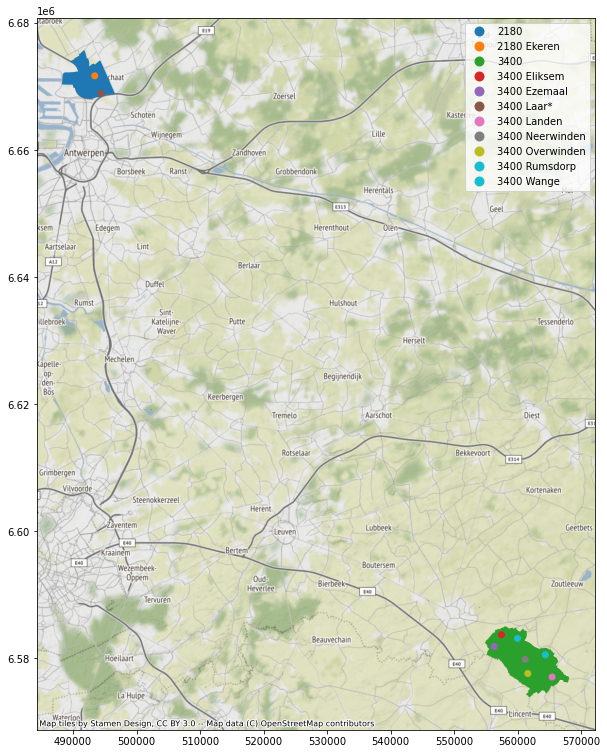

zipcode                                           geometry  \
169     2180  POLYGON Z ((496588.712 6668893.730 0.000, 4964...   
311     3400  POLYGON Z ((558689.985 6584691.286 0.000, 5587...   
594     2180                     POINT (493399.941 6671721.019)   
647     3400                     POINT (556300.652 6581875.841)   
648     3400                     POINT (564340.440 6580563.701)   
1244    3400                     POINT (557431.485 6583720.469)   
1245    3400                     POINT (494374.378 6668971.891)   
1246    3400                     POINT (561161.283 6579870.014)   
1247    3400                     POINT (561584.848 6577616.941)   
1789    3400                     POINT (559967.361 6583146.119)   
2308    3400                     POINT (565402.449 6577069.971)   

                label  
169              2180  
311              3400  
594       2180 Ekeren  
647      3400 Ezemaal  
648     3400 Rumsdorp  
1244     3400 Eliksem  
1245       3400 Laar*  
1246  3400 Neerwinden  
1247  3400 Overwinden  
1789       3400 Wange  
2308      3400 Landen

--------------
Mismatch record 19:


zipcode_left  is_special  \
19         4122       False   

                                             geometry  index_right locality  \
19  POLYGON Z ((617503.511 6544062.555 0.000, 6175...          701   Neupré   

   zipcode_right  
19          4120

From BPost:


zipcode         locality Sous-commune main_commune Province  is_special
596     4120            Ehein          Oui       NEUPRÉ    LIEGE       False
1918    4122       Plainevaux          Oui       NEUPRÉ    LIEGE       False
2056    4120  Rotheux-Rimière          Oui       NEUPRÉ    LIEGE       False

Know by OSM at the given point:
Route du Condroz, Rotheux-Rimière, Neupré, Liège, Wallonie, 4120, België / Belgique / Belgien
Know by OSM for the given locality:
Neupré, Liège, Wallonie, 4120, België / Belgique / Belgien


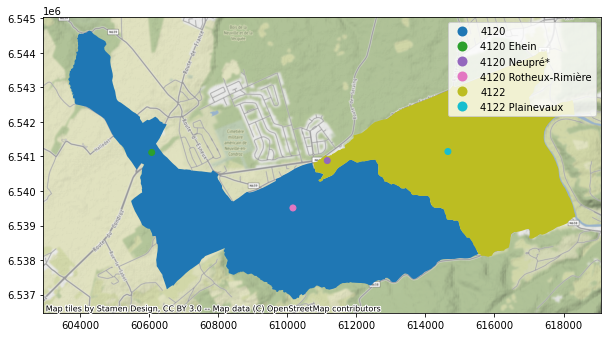

zipcode                                           geometry  \
411     4120  POLYGON Z ((604356.408 6544578.503 0.000, 6043...   
413     4122  POLYGON Z ((617503.511 6544062.555 0.000, 6175...   
701     4120                     POINT (611156.016 6540881.061)   
702     4120                     POINT (610162.122 6539508.443)   
1290    4122                     POINT (614650.691 6541144.169)   
2364    4120                     POINT (606071.687 6541115.511)   

                     label  
411                   4120  
413                   4122  
701           4120 Neupré*  
702   4120 Rotheux-Rimière  
1290       4122 Plainevaux  
2364            4120 Ehein

--------------
Mismatch record 25:


zipcode_left  is_special  \
25         4910       False   

                                             geometry  index_right locality  \
25  POLYGON Z ((654464.107 6535116.816 0.000, 6544...         2423  Polleur   

   zipcode_right  
25          4800

From BPost:


zipcode       locality Sous-commune main_commune Province  is_special
632     4800        Ensival          Oui     VERVIERS    LIEGE       False
1264    4910        La Reid          Oui        THEUX    LIEGE       False
1275    4800     Lambermont          Oui     VERVIERS    LIEGE       False
1904    4800  Petit-Rechain          Oui     VERVIERS    LIEGE       False
1926    4800        Polleur          Oui     VERVIERS    LIEGE       False
1927    4910        Polleur          Oui        THEUX    LIEGE       False
2345    4910          Theux          Non        THEUX    LIEGE       False
2457    4800       Verviers          Non     VERVIERS    LIEGE       False

Know by OSM at the given point:
Thier de Polleur, Polleur, Theux, Verviers, Liège, Wallonie, 4910, België / Belgique / Belgien
Know by OSM for the given locality:
Polleur, Theux, Verviers, Liège, Wallonie, 4910, België / Belgique / Belgien


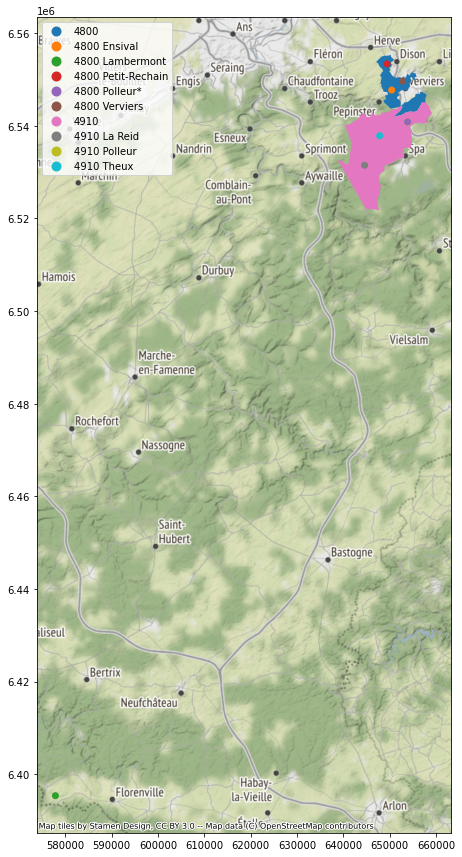

zipcode                                           geometry  \
523     4800  MULTIPOLYGON Z (((656867.329 6547416.177 0.000...   
545     4910  POLYGON Z ((654464.107 6535116.816 0.000, 6544...   
209     4800                     POINT (652761.286 6549653.344)   
215     4910                     POINT (644602.903 6531477.055)   
774     4800                     POINT (577859.588 6395375.603)   
1349    4910                     POINT (653882.825 6540834.098)   
1904    4910                     POINT (647867.813 6537848.675)   
2421    4800                     POINT (650460.045 6547714.947)   
2422    4800                     POINT (649457.769 6553350.139)   
2423    4800                     POINT (653882.825 6540834.098)   

                   label  
523                 4800  
545                 4910  
209        4800 Verviers  
215         4910 La Reid  
774      4800 Lambermont  
1349        4910 Polleur  
1904          4910 Theux  
2421        4800 Ensival  
2422  4800 Petit-Rechain  
2423       4800 Polleur*

--------------
Mismatch record 30:


zipcode_left  is_special  \
30         5541       False   

                                             geometry  index_right  locality  \
30  POLYGON Z ((538168.187 6483865.512 0.000, 5382...          835  Hastière   

   zipcode_right  
30          5540

From BPost:


zipcode            locality Sous-commune main_commune Province  \
961     5540     Hastière-Lavaux          Oui     HASTIÈRE    NAMUR   
962     5541   Hastière-Par-Delà          Oui     HASTIÈRE    NAMUR   
1020    5540  Hermeton-Sur-Meuse          Oui     HASTIÈRE    NAMUR   
2615    5540            Waulsort          Oui     HASTIÈRE    NAMUR   

      is_special  
961        False  
962        False  
1020       False  
2615       False

Know by OSM at the given point:
Hermeton-sur-Meuse, Hastière, Dinant, Namur, Wallonie, 5540, België / Belgique / Belgien
Know by OSM for the given locality:
Hastière, Dinant, Namur, Wallonie, België / Belgique / Belgien


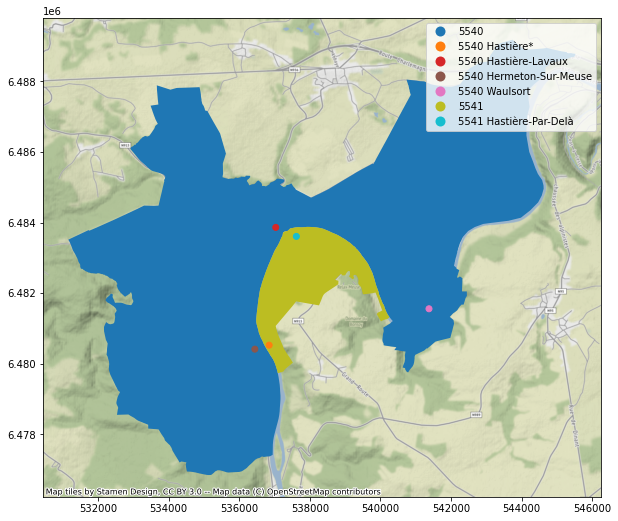

zipcode                                           geometry  \
614     5540  POLYGON Z ((543741.262 6489179.756 0.000, 5440...   
615     5541  POLYGON Z ((538168.187 6483865.512 0.000, 5382...   
254     5540                     POINT (536439.598 6480412.186)   
255     5541                     POINT (537615.856 6483606.989)   
835     5540                     POINT (536844.276 6480524.871)   
836     5540                     POINT (541373.979 6481556.563)   
1396    5540                     POINT (537032.196 6483861.725)   

                        label  
614                      5540  
615                      5541  
254   5540 Hermeton-Sur-Meuse  
255    5541 Hastière-Par-Delà  
835            5540 Hastière*  
836             5540 Waulsort  
1396     5540 Hastière-Lavaux

--------------
Mismatch record 43:


zipcode_left  is_special  \
43         8952       False   

                                             geometry  index_right  \
43  POLYGON Z ((317308.967 6581658.756 0.000, 3172...         2694   

      locality zipcode_right  
43  Heuvelland          8950

From BPost:


zipcode    locality Sous-commune main_commune             Province  \
1714    8950  Nieuwkerke          Oui   HEUVELLAND  FLANDRE-OCCIDENTALE   
2707    8952   Wulvergem          Oui   HEUVELLAND  FLANDRE-OCCIDENTALE   

      is_special  
1714       False  
2707       False

Know by OSM at the given point:
11, Vrooilandstraat, Wulvergem, Heuvelland, Ieper, West-Vlaanderen, Vlaanderen, 8952, België / Belgique / Belgien
Know by OSM for the given locality:
Heuvelland, Ieper, West-Vlaanderen, Vlaanderen, België / Belgique / Belgien


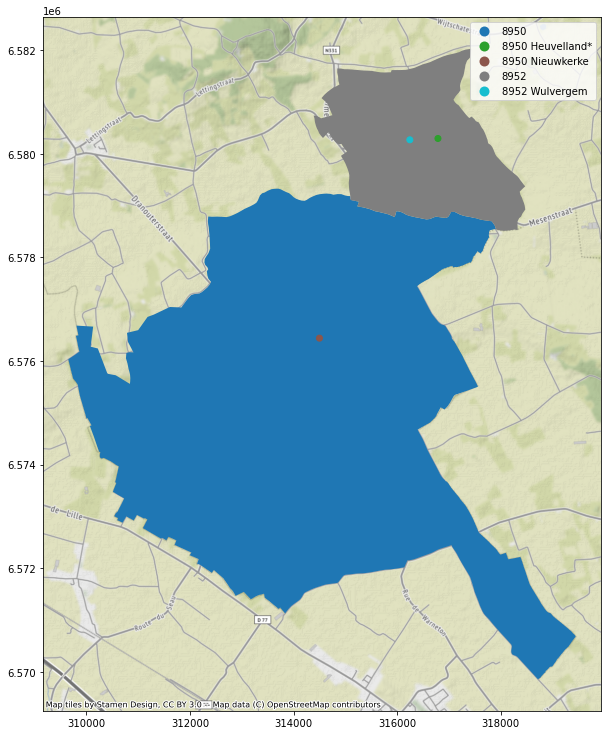

zipcode                                           geometry  \
1059    8950  POLYGON Z ((314156.302 6579096.091 0.000, 3142...   
1061    8952  POLYGON Z ((317308.967 6581658.756 0.000, 3172...   
484     8952                     POINT (316244.117 6580270.370)   
1071    8950                     POINT (314499.068 6576440.484)   
2694    8950                     POINT (316786.986 6580295.900)   

                 label  
1059              8950  
1061              8952  
484     8952 Wulvergem  
1071   8950 Nieuwkerke  
2694  8950 Heuvelland*

--------------


In [78]:
# for i in range(sjoin_mismatches.shape[0]):
for i in [8, 19, 25, 30, 43]:
    plot_mismatch_zip(sjoin_mismatches, i)
    print("--------------")

In [47]:
# All "Antwerpen" centers are set to the same place
zipcodes_centers[(zipcodes_centers.locality=="Antwerpen")]

locality zipcode                        geometry
592   Antwerpen    2000  POINT (489773.265 6660499.059)
593   Antwerpen    2050  POINT (489773.265 6660499.059)
1198  Antwerpen    2040  POINT (489773.265 6660499.059)
1736  Antwerpen    2020  POINT (489773.265 6660499.059)
2255  Antwerpen    2018  POINT (489773.265 6660499.059)
2256  Antwerpen    2030  POINT (489773.265 6660499.059)
2259  Antwerpen    2060  POINT (489773.265 6660499.059)

# Spatial join: polygon vs polygon

As as second example, we join polygons (main communes from postal data, merging zipcode boundaries) to polygons (from nis code boundaries). This will allow us: 

- Detect mismatch between the sources
- Map a commune (name) from postal data to its corresponding name in NIS data
- As a side effect, map a zip code to its (enclosing) nis code

The main difficulty resides in the fact that the two sources do not have the same level of precision, which makes that often, 
a zone from one source have a very small overlap to is neighbor zone in the other source. 

First step: group zipcodes boundaries by main commune. We need to exclude "special code"

In [50]:
# Remove all special codes (note: special codes from  zipcodes_boundaries and zipcodes are note fully coherent. 
# Data from zipcodes seems to be more reliable)
zipcodes_boundaries_normal = zipcodes_boundaries[~zipcodes_boundaries.zipcode.isin(zipcodes[zipcodes.is_special].zipcode)]

Then we merge zipcodes boundaries by main commune

In [51]:
main_commune_boundaries = zipcodes_boundaries_normal.merge(zipcodes[["zipcode","main_commune"]].drop_duplicates())[["main_commune", "geometry"]].dissolve("main_commune").reset_index()

And fill the holes left by special code

In [52]:
def close_holes(poly: shapely.geometry.Polygon) -> shapely.geometry.Polygon:
        """
        Close polygon holes by limitation to the exterior ring.
        Args:
            poly: Input shapely Polygon
        Example:
            df.geometry.apply(lambda p: close_holes(p))
        """
        if isinstance(poly, shapely.geometry.Polygon) and poly.interiors:
            return shapely.geometry.Polygon(list(poly.exterior.coords))
        else:
            return poly

main_commune_boundaries.geometry = main_commune_boundaries.geometry.apply(lambda p: close_holes(p))

In [53]:
# Consistency check : do we have the same number of main communes in the two dataset?
print("Number of main communes:", main_commune_boundaries.shape[0])
print("Number of nis codes    :", nis_boundaries.shape[0])

Number of main communes: 581
Number of nis codes    : 581


In [54]:
sjoin_zip_nis_bnd = gpd.sjoin(main_commune_boundaries[["main_commune", "geometry"]], 
          nis_boundaries[["niscode",  "T_MUN_FR", "T_MUN_NL", "geometry"]])

sjoin_zip_nis_bnd = sjoin_zip_nis_bnd.merge(nis_boundaries[["geometry"]].rename({"geometry": "geometry_nis"}, axis=1), left_on="index_right", right_index=True )
sjoin_zip_nis_bnd

main_commune                                           geometry  \
0               AALST  POLYGON Z ((444815.290 6610373.362 0.000, 4449...   
123       DENDERLEEUW  POLYGON Z ((452230.458 6598608.491 0.000, 4521...   
149         ERPE-MERE  POLYGON Z ((443724.293 6606512.588 0.000, 4436...   
205          HAALTERT  POLYGON Z ((443723.645 6606499.476 0.000, 4437...   
235           HERZELE  POLYGON Z ((435961.441 6600303.285 0.000, 4360...   
..                ...                                                ...   
526            VIRTON  POLYGON Z ((612667.628 6372176.415 0.000, 6127...   
370     MOERBEKE-WAAS  POLYGON Z ((442800.468 6661195.878 0.000, 4428...   
473  SINT-GILLIS-WAAS  POLYGON Z ((463162.161 6657229.671 0.000, 4631...   
478      SINT-NIKLAAS  POLYGON Z ((454823.432 6652387.635 0.000, 4548...   
492           STEKENE  POLYGON Z ((451854.682 6653896.124 0.000, 4518...   

     index_right niscode  T_MUN_FR  T_MUN_NL  \
0            247   41024  Haaltert  Haaltert   
123          247   41024  Haaltert  Haaltert   
149          247   41024  Haaltert  Haaltert   
205          247   41024  Haaltert  Haaltert   
235          247   41024  Haaltert  Haaltert   
..           ...     ...       ...       ...   
526          542   85047   Rouvroy   Rouvroy   
370          302   46024   Stekene   Stekene   
473          302   46024   Stekene   Stekene   
478          302   46024   Stekene   Stekene   
492          302   46024   Stekene   Stekene   

                                          geometry_nis  
0    POLYGON Z ((444954.143 6596751.042 0.000, 4449...  
123  POLYGON Z ((444954.143 6596751.042 0.000, 4449...  
149  POLYGON Z ((444954.143 6596751.042 0.000, 4449...  
205  POLYGON Z ((444954.143 6596751.042 0.000, 4449...  
235  POLYGON Z ((444954.143 6596751.042 0.000, 4449...  
..                                                 ...  
526  POLYGON Z ((614367.944 6362984.609 0.000, 6143...  
370  POLYGON Z ((446225.697 6652626.710 0.000, 4462...  
473  POLYGON Z ((446225.697 6652626.710 0.000, 4462...  
478  POLYGON Z ((446225.697 6652626.710 0.000, 4462...  
492  POLYGON Z ((446225.697 6652626.710 0.000, 4462...  

[3802 rows x 7 columns]

In [55]:
def get_intersection_area(rec):
    try : 
        return rec.geometry.intersection(rec.geometry_nis).area
    except shapely.errors.TopologicalError :
        return rec.geometry.intersection(rec.geometry_nis.buffer(0.01)).area
        #return None

In [56]:
sjoin_zip_nis_bnd["intersect_area"] = sjoin_zip_nis_bnd.apply(get_intersection_area, axis=1)

If the intersection between the two zones is "low", we consider that this is due to two "touching" zones, while if the intersection is "high", we have two realy overlapping zones.

So what it "low" ?

We first consider the (logarithmic) distribution of the intersection area (in square meters). There are clearly two separete regions, but finding a threshold might not that easy

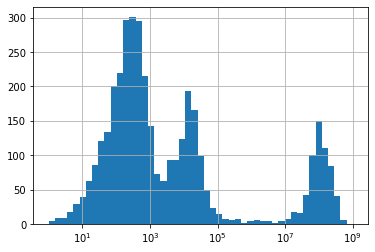

In [57]:
sjoin_zip_nis_bnd.intersect_area.hist(bins=10**np.linspace(0, 9))
plt.xscale('log')

If, instead of considering the intersection are, we consider the intersection ratio, the two regions are much better separated. 

In [58]:
sjoin_zip_nis_bnd["intersect_area_ratio_zip"] = sjoin_zip_nis_bnd["intersect_area"]/sjoin_zip_nis_bnd.area
sjoin_zip_nis_bnd["intersect_area_ratio_nis"] = sjoin_zip_nis_bnd["intersect_area"]/sjoin_zip_nis_bnd.geometry_nis.area

Text(0.5, 1.0, 'Intersection ratio vs Zip')

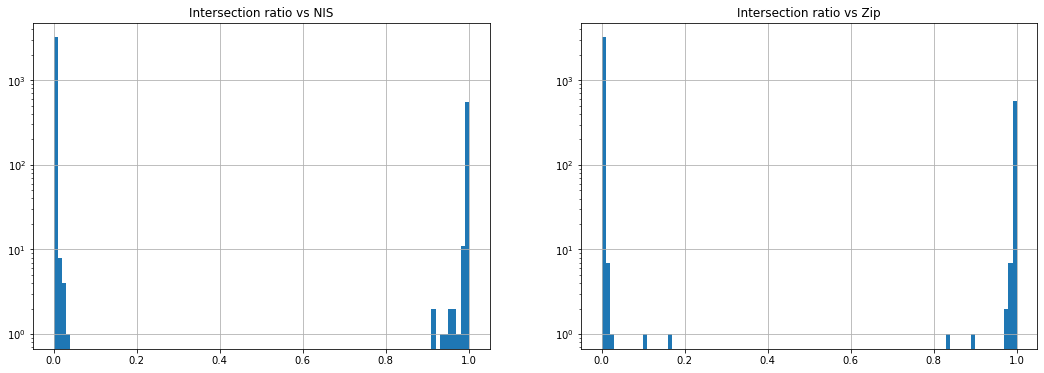

In [59]:
f,ax = plt.subplots(1,2,figsize=(18, 6))
sjoin_zip_nis_bnd.intersect_area_ratio_nis.hist(bins=100, log=True, ax=ax[0]) ; ax[0].set_title("Intersection ratio vs NIS")
sjoin_zip_nis_bnd.intersect_area_ratio_zip.hist(bins=100, log=True, ax=ax[1]) ; ax[1].set_title("Intersection ratio vs Zip")

But we have still a few values to further investigated.

We have to map every commune (from zipcode data) to one (and only one) nis, and vice-versa. 

If we take a too low threshold, we migth map a commune (from zipcode) to more than one nis

If we take a too high threshold, we might not map commune to any nis.

From the graph bellow, we see that for a threshold between 0.2 and 0.8, every single zip commune is mapped to a single nis.

  0%|          | 0/97 [00:00<?, ?it/s]

<AxesSubplot:xlabel='thresh'>

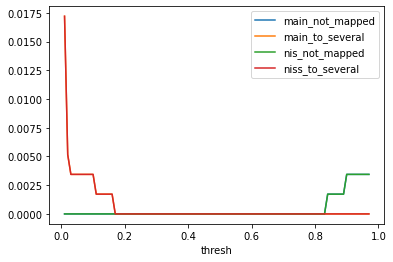

In [60]:
area_thresholds=[]
from tqdm.auto import tqdm
for th in tqdm(range(1, 98, 1)):

    query = f"intersect_area_ratio_zip>{th/100.0}"
    
    main_to_one_nis = sjoin_zip_nis_bnd.query(query).groupby("main_commune").niscode.count().value_counts().loc[1]/sjoin_zip_nis_bnd.main_commune.nunique()
    nis_to_one_main = sjoin_zip_nis_bnd.query(query).groupby("niscode").main_commune.count().value_counts().loc[1]/sjoin_zip_nis_bnd.niscode.nunique()
    
    main_not_mapped = (sjoin_zip_nis_bnd.main_commune.nunique() - sjoin_zip_nis_bnd.query(query).main_commune.nunique() ) / sjoin_zip_nis_bnd.main_commune.nunique()
    main_to_several = sjoin_zip_nis_bnd.query(query).main_commune.duplicated().sum() /  sjoin_zip_nis_bnd.main_commune.nunique()

    nis_not_mapped = (sjoin_zip_nis_bnd.niscode.nunique() - sjoin_zip_nis_bnd.query(query).niscode.nunique() ) / sjoin_zip_nis_bnd.niscode.nunique()
    nis_to_several = sjoin_zip_nis_bnd.query(query).niscode.duplicated().sum() /  sjoin_zip_nis_bnd.niscode.nunique()

    area_thresholds.append({"thresh":th/100, 
                           #"main_to_one_nis": main_to_one_nis,
                           #"nis_to_one_main": nis_to_one_main,
                           "main_not_mapped": main_not_mapped,
                           "main_to_several": main_to_several,
                           "nis_not_mapped":  nis_not_mapped,
                           "niss_to_several": nis_to_several,
                           
                           })
    
area_thresholds = pd.DataFrame(area_thresholds).set_index("thresh")  
area_thresholds.plot()
# area_thresholds

## Detect ambiguities

We will here plot the "ambiguities", i.e., zip commune with a "rather high" overlap to more that one nis commune

In [61]:
sjoin_ambiguities = sjoin_zip_nis_bnd[sjoin_zip_nis_bnd.intersect_area_ratio_zip.between(0.02, 0.98) |
                                      sjoin_zip_nis_bnd.intersect_area_ratio_nis.between(0.02, 0.98)].reset_index(drop=True)
sjoin_ambiguities

main_commune  \
0                    BRUXELLES   
1                    ETTERBEEK   
2                      IXELLES   
3                    DROGENBOS   
4           SINT-PIETERS-LEEUW   
5                      IXELLES   
6                    ETTERBEEK   
7                BAARLE-HERTOG   
8                  HOOGSTRATEN   
9                    MERKSPLAS   
10                     DE HAAN   
11                KNOKKE-HEIST   
12                    MACHELEN   
13                   VILVOORDE   
14               HAM-SUR-HEURE   
15               HAM-SUR-HEURE   
16          MONT-SAINT-GUIBERT   
17  OTTIGNIES-LOUVAIN-LA-NEUVE   
18                 MIDDELKERKE   
19                      RAEREN   

                                             geometry  index_right niscode  \
0   MULTIPOLYGON Z (((488053.262 6588268.829 0.000...           72   21004   
1   MULTIPOLYGON Z (((486480.015 6594068.947 0.000...           72   21004   
2   MULTIPOLYGON Z (((486898.793 6593112.249 0.000...           72   21004   
3   POLYGON Z ((478880.939 6588291.060 0.000, 4791...          115   23098   
4   POLYGON Z ((478752.588 6588151.699 0.000, 4787...          115   23098   
5   MULTIPOLYGON Z (((486898.793 6593112.249 0.000...           77   21009   
6   MULTIPOLYGON Z (((486480.015 6594068.947 0.000...           73   21005   
7   MULTIPOLYGON Z (((549450.124 6694015.813 0.000...           43   13002   
8   POLYGON Z ((530883.120 6690348.947 0.000, 5308...           43   13002   
9   POLYGON Z ((539878.978 6694908.114 0.000, 5398...           43   13002   
10  POLYGON Z ((340736.309 6662510.388 0.000, 3407...          221   35029   
11  POLYGON Z ((365382.764 6674880.153 0.000, 3651...          189   31043   
12  POLYGON Z ((496647.562 6604155.100 0.000, 4966...          102   23047   
13  POLYGON Z ((498419.171 6613872.678 0.000, 4984...          111   23088   
14  POLYGON Z ((493020.407 6509850.882 0.000, 4929...          355   56086   
15  POLYGON Z ((493020.407 6509850.882 0.000, 4929...          316   52011   
16  MULTIPOLYGON Z (((517835.977 6561659.841 0.000...          164   25068   
17  POLYGON Z ((513291.512 6561137.196 0.000, 5132...          164   25068   
18  POLYGON Z ((317462.612 6655594.988 0.000, 3174...          218   35011   
19  POLYGON Z ((683436.351 6566996.135 0.000, 6836...          430   63061   

                  T_MUN_FR                T_MUN_NL  \
0                Bruxelles                 Brussel   
1                Bruxelles                 Brussel   
2                Bruxelles                 Brussel   
3                Drogenbos               Drogenbos   
4                Drogenbos               Drogenbos   
5                  Ixelles                  Elsene   
6                Etterbeek               Etterbeek   
7               Baerle-Duc           Baarle-Hertog   
8               Baerle-Duc           Baarle-Hertog   
9               Baerle-Duc           Baarle-Hertog   
10                 De Haan                 De Haan   
11            Knokke-Heist            Knokke-Heist   
12                Machelen                Machelen   
13                Vilvorde               Vilvoorde   
14  Ham-sur-Heure-Nalinnes  Ham-sur-Heure-Nalinnes   
15               Charleroi               Charleroi   
16      Mont-Saint-Guibert      Mont-Saint-Guibert   
17      Mont-Saint-Guibert      Mont-Saint-Guibert   
18             Middelkerke             Middelkerke   
19                  Raeren                  Raeren   

                                         geometry_nis  intersect_area  \
0   POLYGON Z ((489511.425 6586199.186 0.000, 4895...    7.770481e+07   
1   POLYGON Z ((489511.425 6586199.186 0.000, 4895...    1.518269e+06   
2   POLYGON Z ((489511.425 6586199.186 0.000, 4895...    1.841104e+06   
3   POLYGON Z ((480801.458 6582450.394 0.000, 4802...    5.995117e+06   
4   POLYGON Z ((480801.458 6582450.394 0.000, 4802...    2.425125e+05   
5   MULTIPOLYGON Z (((489029.873 6586179.784 0.000...    1.588645e+07   
6   POLYGON Z ((48

In [62]:
# We create cluster, to set together records about the same zone
sjoin_ambiguities["cluster_id"] = sjoin_ambiguities.index
for i, rec in sjoin_ambiguities.iterrows():
    x = sjoin_ambiguities.loc[:i]
    x = x[(x.main_commune == rec.main_commune) | (x.niscode == rec.niscode) ]
    
    if x.shape[0]>0:
        sjoin_ambiguities.loc[i, "cluster_id"] = x.cluster_id.min()    

In [63]:
def plot_mismatch(cluster_id):
    rec = sjoin_ambiguities[sjoin_ambiguities.cluster_id==cluster_id]
    
    display(rec)
    #display(zipcodes[zipcodes.main_commune==main_commune])

    r_nis=nis_boundaries[nis_boundaries.niscode.isin(rec.niscode)].assign(kind="nis")
    r_zip=main_commune_boundaries[main_commune_boundaries.main_commune.isin(rec.main_commune)].assign(kind="zip")
    r_nis["label"] = r_nis.T_MUN_FR+" (nis)"
    r_zip["label"] = r_zip.main_commune +" (zip)"
    
    polygons= pd.concat([r_nis, r_zip])[["label", "geometry", "kind"]]
        
        
    polygons=polygons.to_crs(osm_crs)

    if with_plotly:
        fig = px.choropleth_mapbox(polygons, 
                           geojson=polygons.geometry, 
                           locations=polygons.index, 
                           hover_name="label",
                           color=polygons['label'],
                           center={"lat": polygons.bounds.mean()[["miny", "maxy"]].mean(), 
                                   "lon": polygons.bounds.mean()[["minx", "maxx"]].mean()},
                           mapbox_style="open-street-map",
                           #zoom=10,
                           opacity=0.5,
         )

        fig.show()
    else: 
        ax = polygons.to_crs(crs).plot("label", legend=True, alpha=0.5, figsize=(15,10))
        try:
            ctx.add_basemap(ax)
        except Exception as  e:
            print("Cannot add basemap: ", e)
        plt.show()


In [79]:
sjoin_ambiguities

main_commune  \
0                    BRUXELLES   
1                    ETTERBEEK   
2                      IXELLES   
3                    DROGENBOS   
4           SINT-PIETERS-LEEUW   
5                      IXELLES   
6                    ETTERBEEK   
7                BAARLE-HERTOG   
8                  HOOGSTRATEN   
9                    MERKSPLAS   
10                     DE HAAN   
11                KNOKKE-HEIST   
12                    MACHELEN   
13                   VILVOORDE   
14               HAM-SUR-HEURE   
15               HAM-SUR-HEURE   
16          MONT-SAINT-GUIBERT   
17  OTTIGNIES-LOUVAIN-LA-NEUVE   
18                 MIDDELKERKE   
19                      RAEREN   

                                             geometry  index_right niscode  \
0   MULTIPOLYGON Z (((488053.262 6588268.829 0.000...           72   21004   
1   MULTIPOLYGON Z (((486480.015 6594068.947 0.000...           72   21004   
2   MULTIPOLYGON Z (((486898.793 6593112.249 0.000...           72   21004   
3   POLYGON Z ((478880.939 6588291.060 0.000, 4791...          115   23098   
4   POLYGON Z ((478752.588 6588151.699 0.000, 4787...          115   23098   
5   MULTIPOLYGON Z (((486898.793 6593112.249 0.000...           77   21009   
6   MULTIPOLYGON Z (((486480.015 6594068.947 0.000...           73   21005   
7   MULTIPOLYGON Z (((549450.124 6694015.813 0.000...           43   13002   
8   POLYGON Z ((530883.120 6690348.947 0.000, 5308...           43   13002   
9   POLYGON Z ((539878.978 6694908.114 0.000, 5398...           43   13002   
10  POLYGON Z ((340736.309 6662510.388 0.000, 3407...          221   35029   
11  POLYGON Z ((365382.764 6674880.153 0.000, 3651...          189   31043   
12  POLYGON Z ((496647.562 6604155.100 0.000, 4966...          102   23047   
13  POLYGON Z ((498419.171 6613872.678 0.000, 4984...          111   23088   
14  POLYGON Z ((493020.407 6509850.882 0.000, 4929...          355   56086   
15  POLYGON Z ((493020.407 6509850.882 0.000, 4929...          316   52011   
16  MULTIPOLYGON Z (((517835.977 6561659.841 0.000...          164   25068   
17  POLYGON Z ((513291.512 6561137.196 0.000, 5132...          164   25068   
18  POLYGON Z ((317462.612 6655594.988 0.000, 3174...          218   35011   
19  POLYGON Z ((683436.351 6566996.135 0.000, 6836...          430   63061   

                  T_MUN_FR                T_MUN_NL  \
0                Bruxelles                 Brussel   
1                Bruxelles                 Brussel   
2                Bruxelles                 Brussel   
3                Drogenbos               Drogenbos   
4                Drogenbos               Drogenbos   
5                  Ixelles                  Elsene   
6                Etterbeek               Etterbeek   
7               Baerle-Duc           Baarle-Hertog   
8               Baerle-Duc           Baarle-Hertog   
9               Baerle-Duc           Baarle-Hertog   
10                 De Haan                 De Haan   
11            Knokke-Heist            Knokke-Heist   
12                Machelen                Machelen   
13                Vilvorde               Vilvoorde   
14  Ham-sur-Heure-Nalinnes  Ham-sur-Heure-Nalinnes   
15               Charleroi               Charleroi   
16      Mont-Saint-Guibert      Mont-Saint-Guibert   
17      Mont-Saint-Guibert      Mont-Saint-Guibert   
18             Middelkerke             Middelkerke   
19                  Raeren                  Raeren   

                                         geometry_nis  intersect_area  \
0   POLYGON Z ((489511.425 6586199.186 0.000, 4895...    7.770481e+07   
1   POLYGON Z ((489511.425 6586199.186 0.000, 4895...    1.518269e+06   
2   POLYGON Z ((489511.425 6586199.186 0.000, 4895...    1.841104e+06   
3   POLYGON Z ((480801.458 6582450.394 0.000, 4802...    5.995117e+06   
4   POLYGON Z ((480801.458 6582450.394 0.000, 4802...    2.425125e+05   
5   MULTIPOLYGON Z (((489029.873 6586179.784 0.000...    1.588645e+07   
6   POLYGON Z ((48

main_commune                                           geometry  \
0    BRUXELLES  MULTIPOLYGON Z (((488053.262 6588268.829 0.000...   
1    ETTERBEEK  MULTIPOLYGON Z (((486480.015 6594068.947 0.000...   
2      IXELLES  MULTIPOLYGON Z (((486898.793 6593112.249 0.000...   
5      IXELLES  MULTIPOLYGON Z (((486898.793 6593112.249 0.000...   
6    ETTERBEEK  MULTIPOLYGON Z (((486480.015 6594068.947 0.000...   

   index_right niscode   T_MUN_FR   T_MUN_NL  \
0           72   21004  Bruxelles    Brussel   
1           72   21004  Bruxelles    Brussel   
2           72   21004  Bruxelles    Brussel   
5           77   21009    Ixelles     Elsene   
6           73   21005  Etterbeek  Etterbeek   

                                        geometry_nis  intersect_area  \
0  POLYGON Z ((489511.425 6586199.186 0.000, 4895...    7.770481e+07   
1  POLYGON Z ((489511.425 6586199.186 0.000, 4895...    1.518269e+06   
2  POLYGON Z ((489511.425 6586199.186 0.000, 4895...    1.841104e+06   
5  MULTIPOLYGON Z (((489029.873 6586179.784 0.000...    1.588645e+07   
6  POLYGON Z ((488713.352 6590019.224 0.000, 4886...    7.947716e+06   

   intersect_area_ratio_zip  intersect_area_ratio_nis  cluster_id  
0                  0.999958                  0.936709           0  
1                  0.160291                  0.018302           0  
2                  0.103683                  0.022194           0  
5                  0.894660                  0.990829           0  
6                  0.839078                  0.999655           0

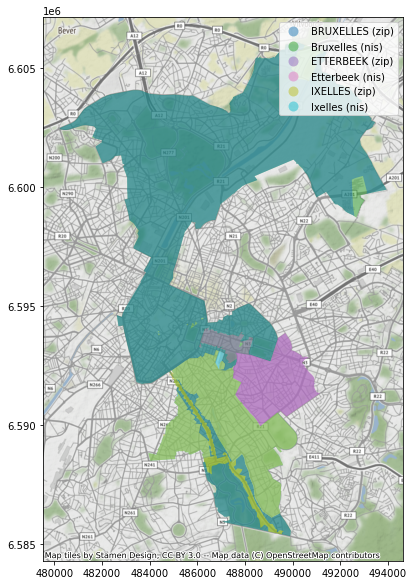

------


main_commune                                           geometry  \
3           DROGENBOS  POLYGON Z ((478880.939 6588291.060 0.000, 4791...   
4  SINT-PIETERS-LEEUW  POLYGON Z ((478752.588 6588151.699 0.000, 4787...   

   index_right niscode   T_MUN_FR   T_MUN_NL  \
3          115   23098  Drogenbos  Drogenbos   
4          115   23098  Drogenbos  Drogenbos   

                                        geometry_nis  intersect_area  \
3  POLYGON Z ((480801.458 6582450.394 0.000, 4802...    5.995117e+06   
4  POLYGON Z ((480801.458 6582450.394 0.000, 4802...    2.425125e+05   

   intersect_area_ratio_zip  intersect_area_ratio_nis  cluster_id  
3                  0.999929                  0.961099           3  
4                  0.002381                  0.038878           3

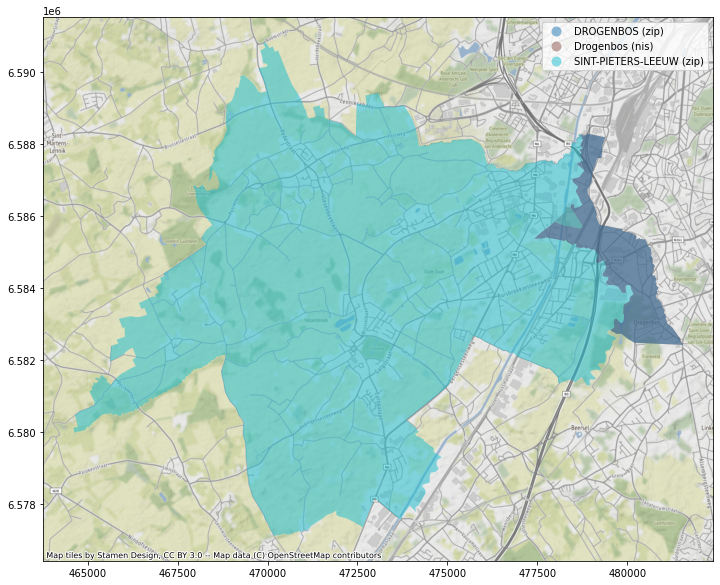

------


main_commune                                           geometry  \
14  HAM-SUR-HEURE  POLYGON Z ((493020.407 6509850.882 0.000, 4929...   
15  HAM-SUR-HEURE  POLYGON Z ((493020.407 6509850.882 0.000, 4929...   

    index_right niscode                T_MUN_FR                T_MUN_NL  \
14          355   56086  Ham-sur-Heure-Nalinnes  Ham-sur-Heure-Nalinnes   
15          316   52011               Charleroi               Charleroi   

                                         geometry_nis  intersect_area  \
14  POLYGON Z ((488808.963 6497099.262 0.000, 4888...    1.098956e+08   
15  POLYGON Z ((494660.639 6507804.215 0.000, 4946...    3.126224e+06   

    intersect_area_ratio_zip  intersect_area_ratio_nis  cluster_id  
14                  0.971590                  0.981020          14  
15                  0.027639                  0.012341          14

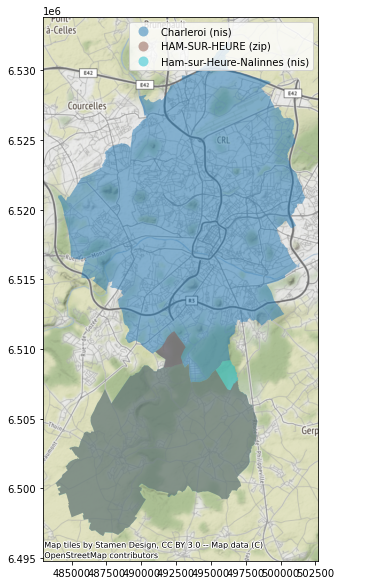

------


main_commune  \
16          MONT-SAINT-GUIBERT   
17  OTTIGNIES-LOUVAIN-LA-NEUVE   

                                             geometry  index_right niscode  \
16  MULTIPOLYGON Z (((517835.977 6561659.841 0.000...          164   25068   
17  POLYGON Z ((513291.512 6561137.196 0.000, 5132...          164   25068   

              T_MUN_FR            T_MUN_NL  \
16  Mont-Saint-Guibert  Mont-Saint-Guibert   
17  Mont-Saint-Guibert  Mont-Saint-Guibert   

                                         geometry_nis  intersect_area  \
16  POLYGON Z ((515737.452 6556309.608 0.000, 5157...    4.538157e+07   
17  POLYGON Z ((515737.452 6556309.608 0.000, 5157...    1.108463e+06   

    intersect_area_ratio_zip  intersect_area_ratio_nis  cluster_id  
16                  0.999979                  0.976041          16  
17                  0.013265                  0.023840          16

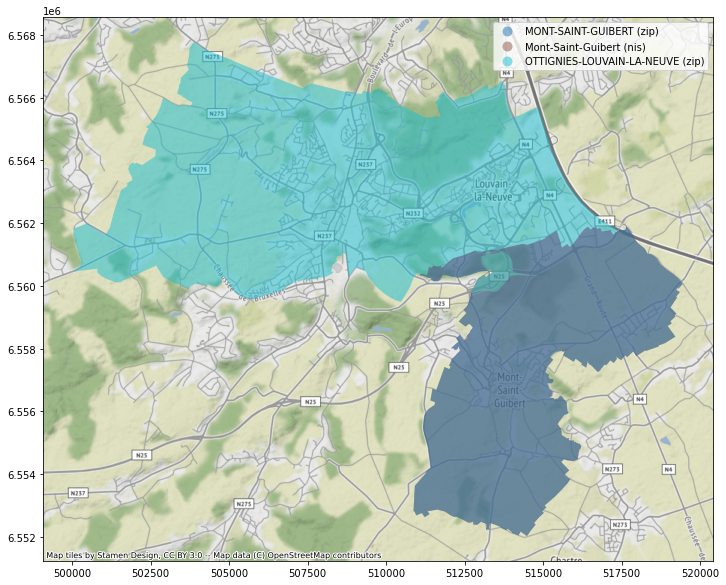

------


main_commune                                           geometry  \
19       RAEREN  POLYGON Z ((683436.351 6566996.135 0.000, 6836...   

    index_right niscode T_MUN_FR T_MUN_NL  \
19          430   63061   Raeren   Raeren   

                                         geometry_nis  intersect_area  \
19  POLYGON Z ((694073.281 6555433.340 0.000, 6941...    1.808707e+08   

    intersect_area_ratio_zip  intersect_area_ratio_nis  cluster_id  
19                  0.974129                  0.999191          19

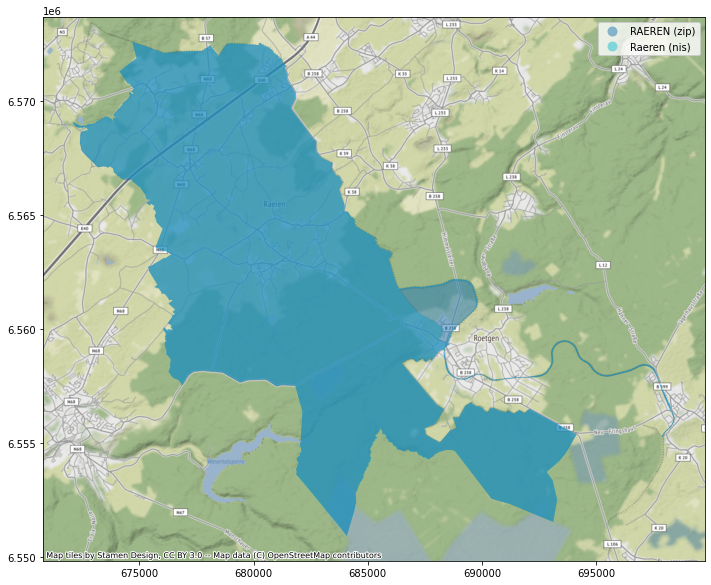

------


In [80]:
# for c_id in sjoin_ambiguities.cluster_id.unique():
for c_id in [0, 3, 14, 16, 19]:    
    plot_mismatch(c_id)
    print("------")

## Map zipcode to niscode

In [66]:
sjoin_safe = sjoin_zip_nis_bnd[sjoin_zip_nis_bnd.intersect_area_ratio_zip >= 0.5]

In [67]:
sjoin_safe.shape[0], sjoin_safe.main_commune.nunique(), sjoin_safe.niscode.nunique()

(581, 581, 581)

In [68]:
zipcodes[["zipcode", "locality", "main_commune"]].merge(sjoin_safe[["main_commune", "niscode"]]).sort_values("zipcode")

zipcode           locality   main_commune niscode
1560    1000          Bruxelles      BRUXELLES   21004
1562    1020             Laeken      BRUXELLES   21004
2682    1030         Schaerbeek     SCHAERBEEK   21015
2065    1040          Etterbeek      ETTERBEEK   21005
2456    1050            Ixelles        IXELLES   21009
...      ...                ...            ...     ...
2692    9988         Watervliet  SINT-LAUREINS   43014
2691    9988  Waterland-Oudeman  SINT-LAUREINS   43014
134     9990           Maldegem       MALDEGEM   43010
133     9991             Adegem       MALDEGEM   43010
135     9992         Middelburg       MALDEGEM   43010

[2721 rows x 4 columns]

## Subcommunes divisions

In [69]:
nis6_per_nis =   statistical_sectors.groupby("CNIS5_2020").C_NIS6.nunique().reset_index().rename({"CNIS5_2020":"niscode",
                                                                                                  "C_NIS6": "nb_nis6"}, axis=1)
locality_per_commune=  zipcodes[~zipcodes.is_special].groupby("main_commune").locality.nunique().reset_index().rename({"locality": "nb_locality"}, axis=1)

In [70]:
locality_counts = sjoin_safe[["main_commune", "niscode"]].merge(locality_per_commune).merge(nis6_per_nis)
locality_counts 

main_commune niscode  nb_locality  nb_nis6
0         HAALTERT   41024            4        5
1      DENDERLEEUW   41011            3        3
2         AFFLIGEM   23105            4        3
3             ASSE   23002            6        6
4        ERPE-MERE   41082            8        8
..             ...     ...          ...      ...
576       LIERNEUX   63045            3        4
577    TROIS-PONTS   63086            4        3
578  MOERBEKE-WAAS   44045            1        1
579        ROUVROY   85047            4        4
580        STEKENE   46024            2        3

[581 rows x 4 columns]

In [71]:
locality_counts[locality_counts.nb_locality != locality_counts.nb_nis6]

main_commune niscode  nb_locality  nb_nis6
0                 HAALTERT   41024            4        5
2                 AFFLIGEM   23105            4        3
16                MALDEGEM   43010            3        4
21   SCHERPENHEUVEL-ZICHEM   24134            5        6
24                   RUMST   11037            3        4
..                     ...     ...          ...      ...
565                 LINTER   24133            8        7
567               WEVELGEM   34041            3        4
576               LIERNEUX   63045            3        4
577            TROIS-PONTS   63086            4        3
580                STEKENE   46024            2        3

[139 rows x 4 columns]

In [72]:
locality_counts[locality_counts.nb_locality != locality_counts.nb_nis6].assign(diff = locality_counts.nb_locality - locality_counts.nb_nis6).sort_values("diff")

main_commune niscode  nb_locality  nb_nis6  diff
31           ANTWERPEN   11002           11       20    -9
390           OOSTENDE   35013            3        7    -4
92               LIÈGE   62063            9       12    -3
168                ATH   51004           19       22    -3
74           BRUXELLES   21004            4        7    -3
..                 ...     ...          ...      ...   ...
425           GEMBLOUX   92142           12        8     4
321             BIÈVRE   91015           10        5     5
320  VRESSE-SUR-SEMOIS   91143           12        7     5
559         OUDENAARDE   45035           14        6     8
108            TOURNAI   57081           30       20    10

[139 rows x 5 columns]

In [76]:
zipcodes[~zipcodes.is_special].groupby("main_commune").locality.nunique().value_counts()


1     98
3     95
4     89
2     67
5     64
6     49
7     28
8     23
9     15
10    14
11     9
12     6
14     5
16     5
15     4
19     3
13     2
17     2
25     1
18     1
30     1
Name: locality, dtype: int64